<a href="https://colab.research.google.com/github/ahanwilson/trading0909/blob/main/butterfly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **蝶式對沖**

### 1.策略原由
對沖需要找到一個穩定的差價，當差價過高（發散）時做空差價，過低（收斂）時做多差價，當差價回歸平倉就賺到了其中的差價。如期現對沖，當未交割期貨價格遠高於現貨時，可以做空期貨合約，做多現貨來做空差價。還有不同交割時間合約的跨期對沖，和期現對沖相比，還能做多差價。期現，跨期都是太常見的策略，競爭也很激烈，平時沒有行情時，差價相對穩定，雖然可以做長期的大行情，但機會少，手動操作也可以。既然都是找穩定的差價，當一個標的物存在三個交易合約時，還有一個差價，即差價的差價，這就是**蝶式對沖**，也被稱為**套利的套利**。

### 2.策略邏輯
幣安幣本位合約如 BTC、ETH 等同時存在三個合約（期貨概念），即永續 BTCUSD_PERP、當季 BTCUSD_200925、次季 BTCUSD_201225。永續合約可以當作現貨，一般兩個合約做對沖共有三個差價：當季-永續、次季-永續、次季-當季。蝶式套利需要操作三個合約，差價為（次季-當季）-（當季-永續）。做多差價需要開做多一份的次季和永續合約，做空2份的當季合約。公式如下：

### 差價 = 次季 + 永續 - 2 * 當季 

### 3.對沖空間
數據採用20200814到20200914的5分k線（時差為8小時）


In [3]:
#導入工具
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
%matplotlib inline

In [5]:
#讀取數據
df = pd.read_csv(f'https://grenade.tw/openData/%E8%9D%B6%E5%BC%8F%E5%B0%8D%E6%B2%96.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail(3)

,BTCUSD_200925,BTCUSD_201225,BTCUSD_PERP,ETHUSD_200925,ETHUSD_201225,ETHUSD_PERP,ADAUSD_200925,ADAUSD_201225,LINKUSD_200925,LINKUSD_PERP,BNBUSD_PERP,TRXUSD_PERP,DOTUSD_PERP,ADAUSD_PERP,LINKUSD_201225,EOSUSD_PERP,LTCUSD_PERP,BCHUSD_PERP,XRPUSD_PERP,ETCUSD_PERP
2020-09-14 02:20:00,10369.9,10509.8,10367.1,366.37,367.78,366.31,0.09493,0.09529,12.040,12.017,29.759,0.03024,5.308,0.09471,12.117,2.719,48.19,223.21,0.2433,5.054
2020-09-14 02:25:00,10366.4,10503.0,10360.4,366.80,367.89,366.33,0.09471,0.09529,12.075,12.048,29.507,0.03025,5.273,0.09453,12.141,2.719,48.11,223.25,0.2440,5.049
2020-09-14 02:30:00,10362.8,10498.6,10356.8,366.13,367.44,365.91,0.09462,0.09520,12.056,12.024,29.493,0.03024,5.280,0.09435,12.118,2.719,48.09,223.10,0.2435,5.055


首先看一下比特幣合約之間的差價，8月17日比特幣價格快速漲了500u，一般為交割的合約相對於現貨處於升水狀態，現貨價格上漲，對未來的預期會更加樂觀，未交割合約和永續之間的差價會變大，如次季-永續的差價達到700u，隨著9月份比特幣價格的下跌，人們的預期迅速變差，次季-永續的差價跌至150u附近，當季-永續幾乎沒有了差價，如果做次季-永續的對沖，只能做長周期大差價的回歸，如果8月決定做400-600之間的差價，現在顯然處於被套牢的狀態。


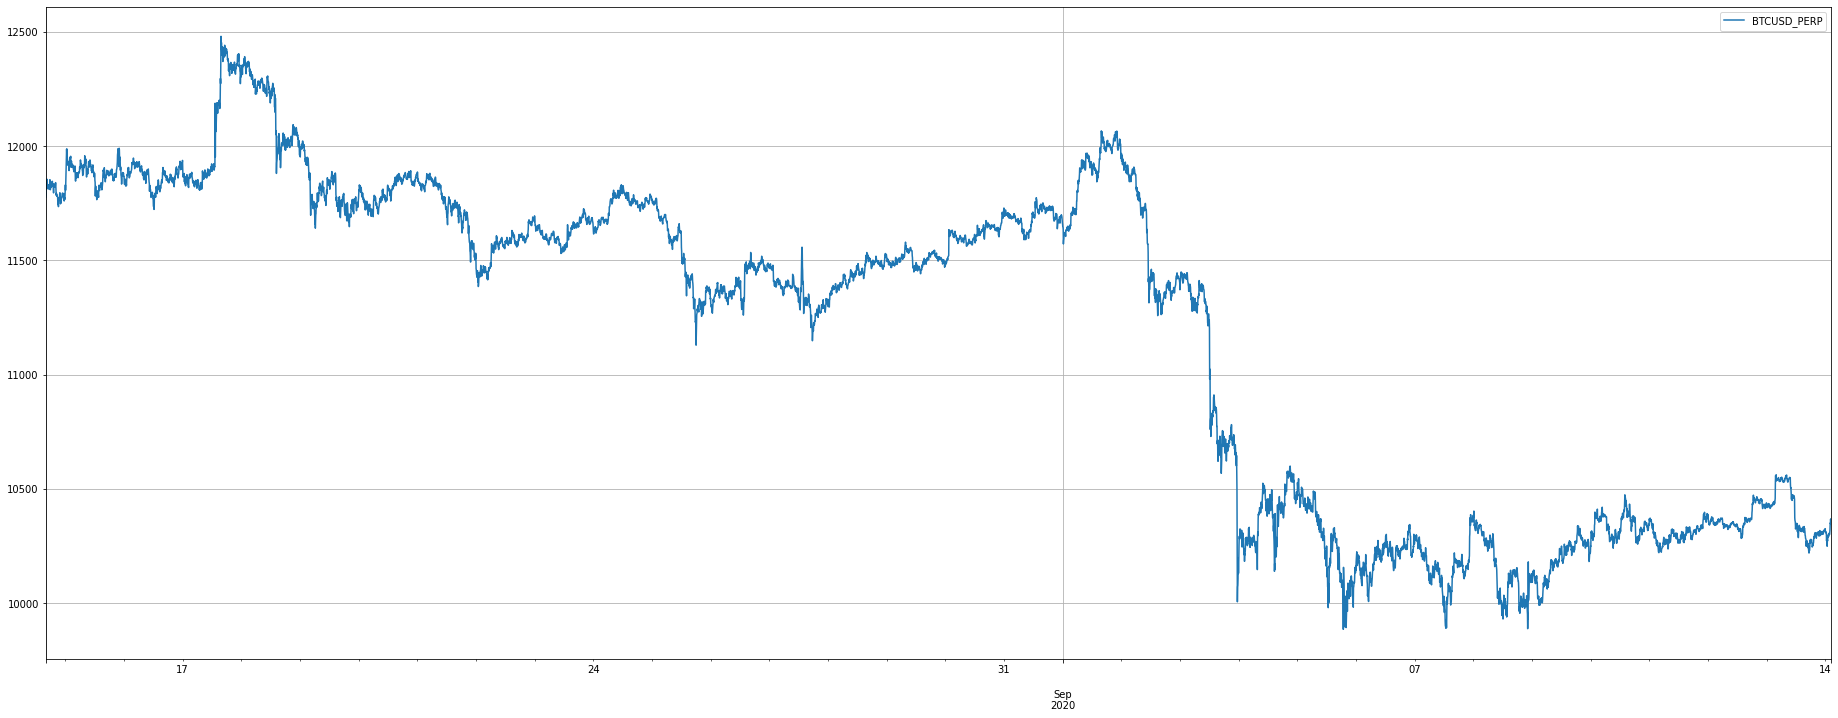

In [6]:
# 永續價格
df['BTCUSD_PERP'].dropna().plot(figsize=(32,12), grid=True, legend=True);

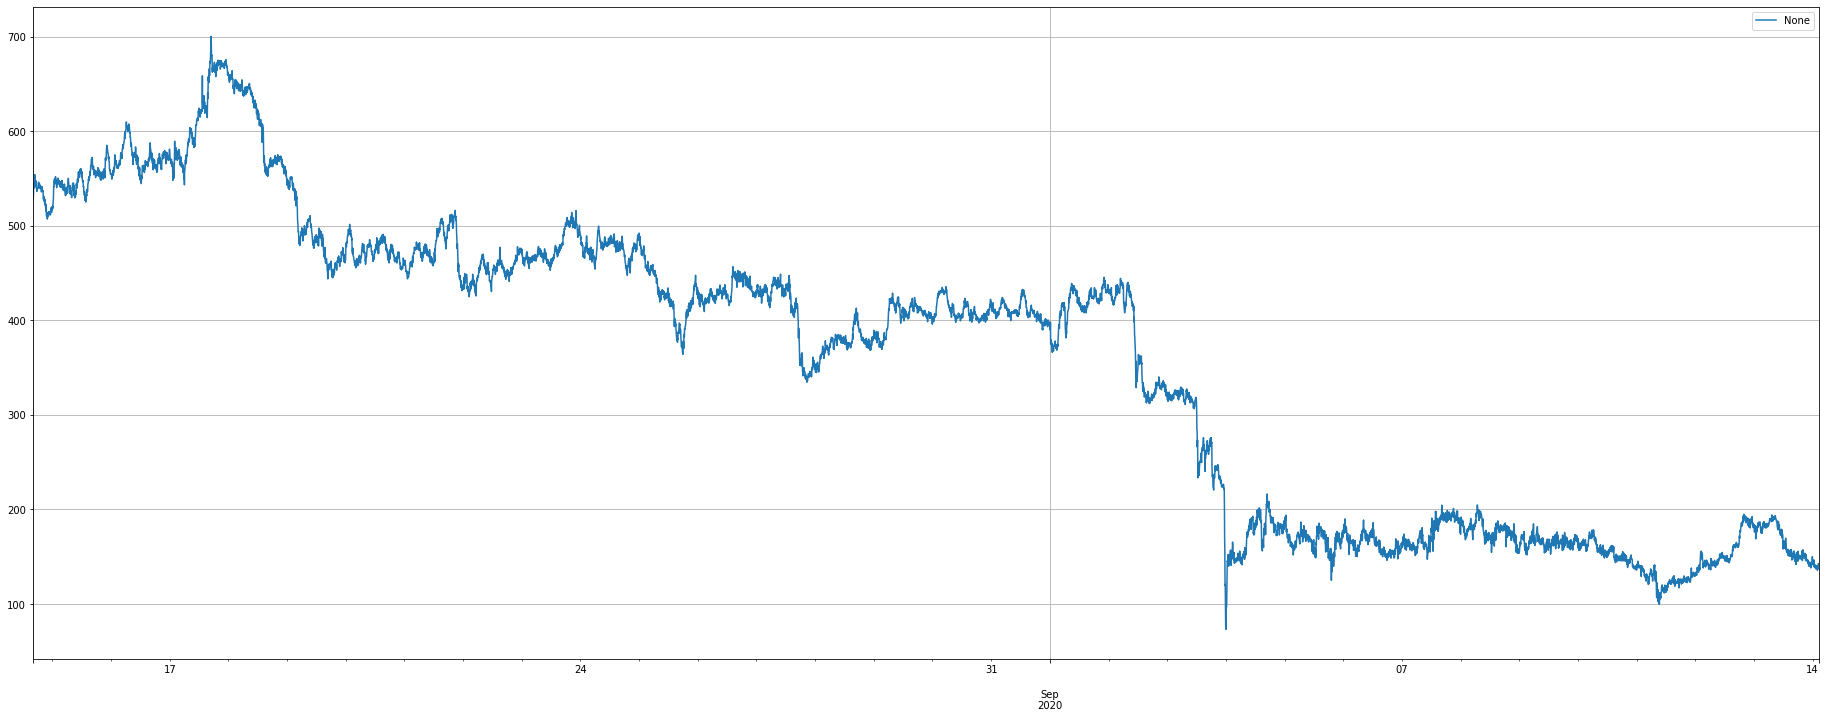

In [7]:
# 次季-永續的差價
(df['BTCUSD_201225']-df['BTCUSD_PERP']).dropna().plot(figsize=(32,12), grid=True, legend=True);

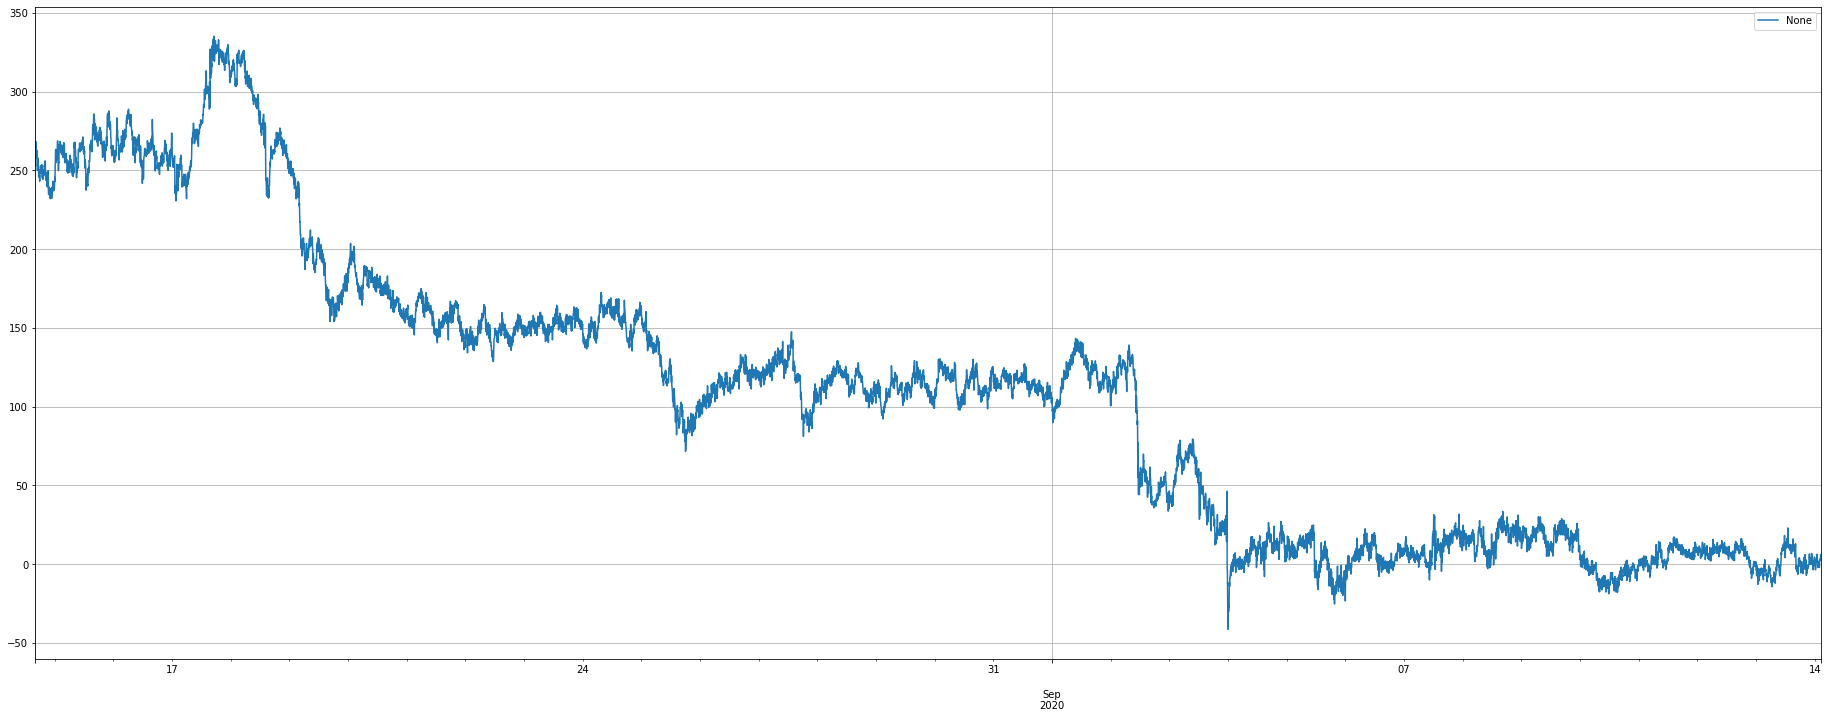

In [8]:
# 當季-永續的差價
(df['BTCUSD_200925']-df['BTCUSD_PERP']).dropna().plot(figsize=(32,12), grid=True, legend=True);


那麼此時差價的差價是如何變動的呢？下圖可以看到，近期差價長期穩定在100-200u，即使9月初的大跌也沒有影響很多，給了我們很多反复套利的空間，目前這個差價如果跌到100u，手動做多也是可以的。

當現貨波動時，兩個未到期合約同時反映了對未來的預期，差價減差價的過程可以很大程度抵消這種波動，表現的相對穩定。 ETH的蝶式套利差價也有類似的表現。

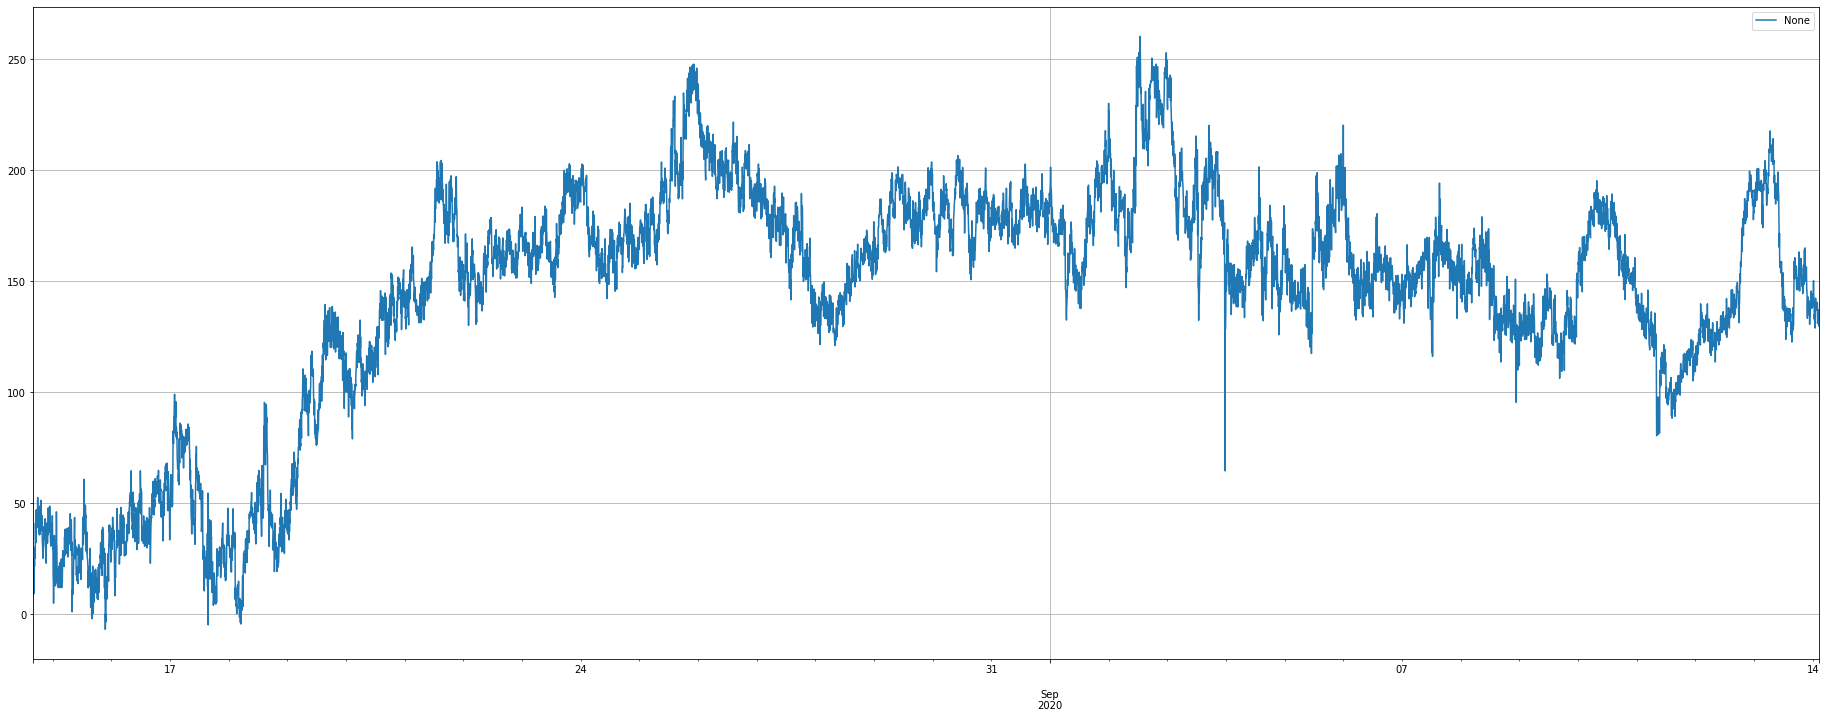

In [10]:
#BTC蝶式對沖
#（次季-當季）-（當季-永續）
(df['BTCUSD_201225']-df['BTCUSD_200925']-(df['BTCUSD_200925']-df['BTCUSD_PERP'])).dropna().plot(figsize=(32,12), grid=True, legend=True);

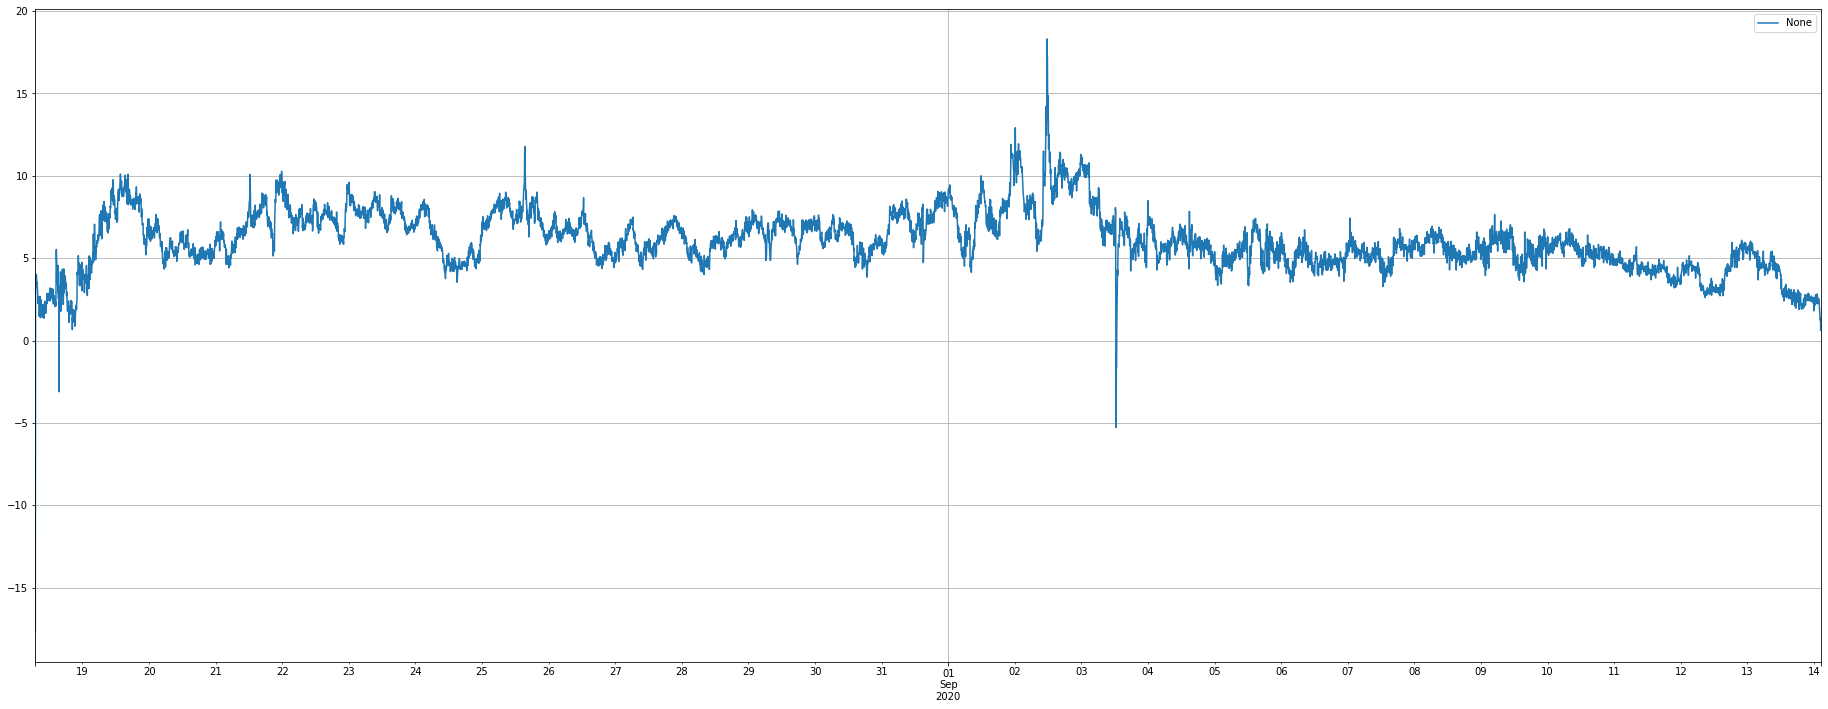

In [12]:
# ETH蝶式對沖
#（次季-當季）-（當季-永續）
(df['ETHUSD_201225']+df['ETHUSD_PERP']-2*df['ETHUSD_200925']).dropna().plot(figsize=(32,12), grid=True, legend=True);

### 4.策略回測
差價的中線用EMA追踪，採用網格的方式來控制倉位，即差價每拉開N份預定的差價（如30），就做空N份，反之依然。如差價中線為100u，當差價為90時，做空3份，差價變為60，平一份。格子的大小是一個關鍵參數。

下面是具體的BTC和ETH的回測代碼和回測結果，表現還算符合預期，由於ETH、LINK的波動更大，差價也更加穩定，表現的好一些。注意這裡的手續費用的是萬2，幣安默認的vip0的taker手續費是萬4，手續費非常重要，接下來的章節專門分析。

In [13]:
# 回測引擎
class Exchange:
    
    def __init__(self, trade_symbols, leverage=20, maker_fee=0.0002, taker_fee=0.0004, log='', initial_balance=10000):
        self.initial_balance = initial_balance #初始的資產
        self.taker_fee = taker_fee
        self.maker_fee = maker_fee
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.df = pd.DataFrame()
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 
                                'total':initial_balance, 'leverage':0, 'fee':0,'maker_fee':0,'taker_fee':0}}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0,
                                    'margin':0, 'unrealised_profit':0,'fee':0}
            
    def Trade(self, symbol, direction, price, amount, msg='', maker=True):
        
        if (self.date and symbol == self.log) or self.log == 'all':
            print('%-26s%-15s%-5s%-10.8s%-8.6s %s'%(str(self.date)[:24], symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))

        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        if maker:
            self.account['USDT']['realised_profit'] -= price*amount*self.maker_fee #扣除手續費
            self.account['USDT']['maker_fee'] += price*amount*self.maker_fee
            self.account['USDT']['fee'] += price*amount*self.maker_fee
            self.account[symbol]['fee'] += price*amount*self.maker_fee
        else:
            self.account['USDT']['realised_profit'] -= price*amount*self.taker_fee #扣除手續費
            self.account['USDT']['taker_fee'] += price*amount*self.taker_fee
            self.account['USDT']['fee'] += price*amount*self.taker_fee
            self.account[symbol]['fee'] += price*amount*self.taker_fee

        
        
        if cover_amount > 0: #先平倉
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利潤
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #釋放保證金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
    
    def Buy(self, symbol, price, amount, msg='', maker=False):
        self.Trade(symbol, 1, price, amount, msg, maker)
        
    def Sell(self, symbol, price, amount, msg='', maker=False):
        self.Trade(symbol, -1, price, amount, msg,maker)
        

    def Update(self, date, symbols, close_price): #對資產進行更新
        self.date = date
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in symbols:
            self.account[symbol]['unrealised_profit'] = (close_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price[symbol]
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price[symbol]
            
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']*self.leverage/self.account['USDT']['total'],4)

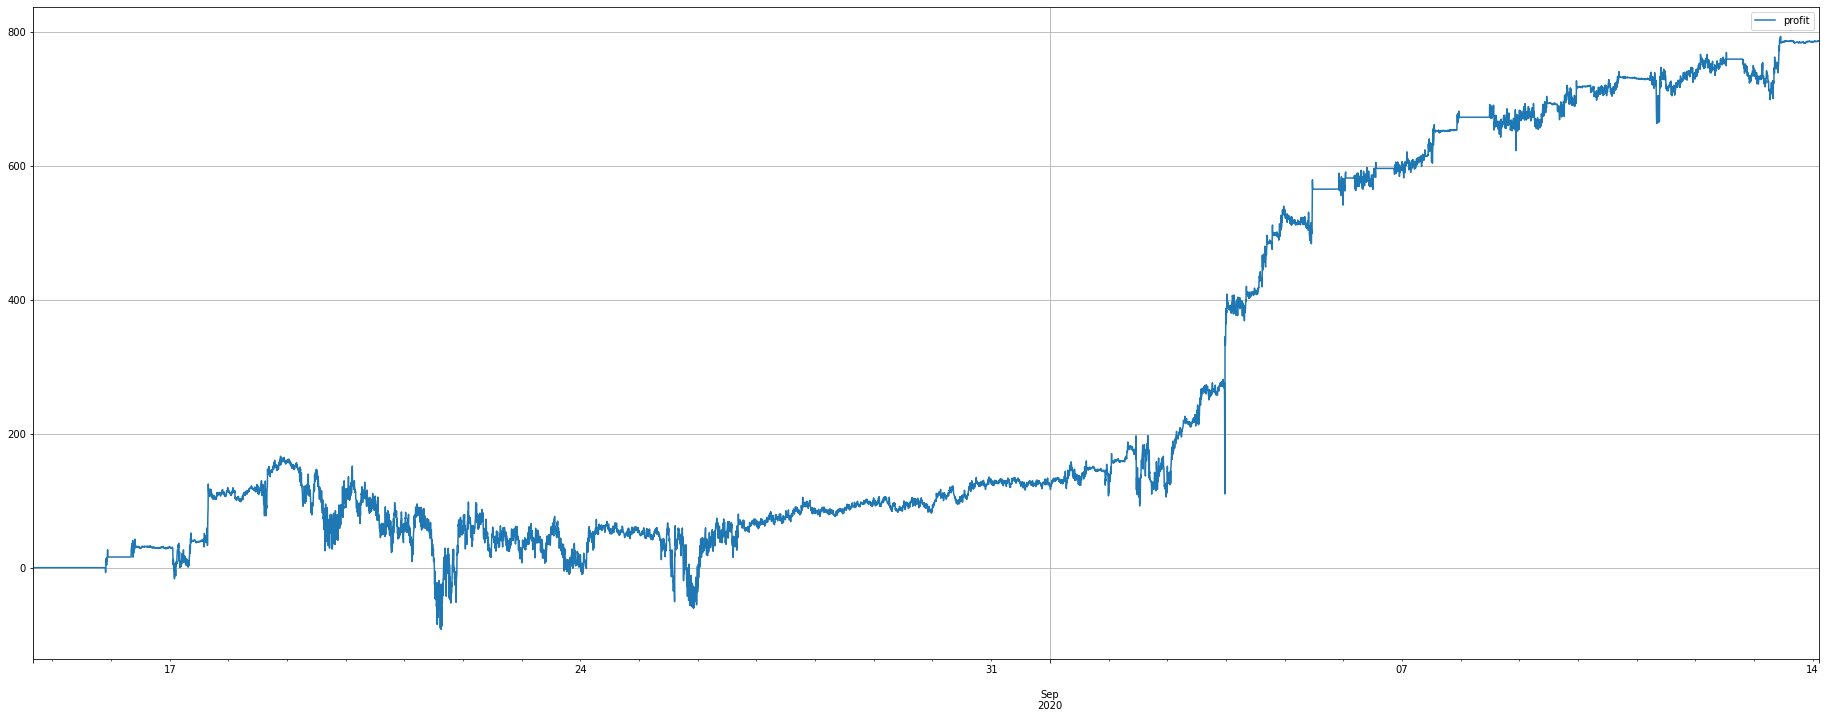

In [14]:
trade_symbols = ['BTCUSD_201225', 'BTCUSD_200925', 'BTCUSD_PERP']
account = []
diff = df['BTCUSD_201225']+df['BTCUSD_PERP']-2*df['BTCUSD_200925']
diff_mean = diff.ewm(alpha=0.001).mean()
e = Exchange(trade_symbols, initial_balance=10000, taker_fee=0.0002)
for row in df[trade_symbols].dropna().iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/30,1)
    now_amount = e.account['BTCUSD_PERP']['amount']
    if aim_amount - now_amount < -1:
        trade_amount = now_amount - aim_amount
        e.Buy('BTCUSD_200925',prices['BTCUSD_200925'],2*trade_amount)
        e.Sell('BTCUSD_201225',prices['BTCUSD_201225'],trade_amount)
        e.Sell('BTCUSD_PERP',prices['BTCUSD_PERP'],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = aim_amount - now_amount
        e.Sell('BTCUSD_200925',prices['BTCUSD_200925'],2*trade_amount)
        e.Buy('BTCUSD_201225',prices['BTCUSD_201225'],trade_amount)
        e.Buy('BTCUSD_PERP',prices['BTCUSD_PERP'],trade_amount)

e.df = pd.DataFrame(index=df[trade_symbols].dropna().index, columns=['margin','profit'], data=account)
e.df['profit'].plot(figsize=(32,12), grid=True, legend=True);

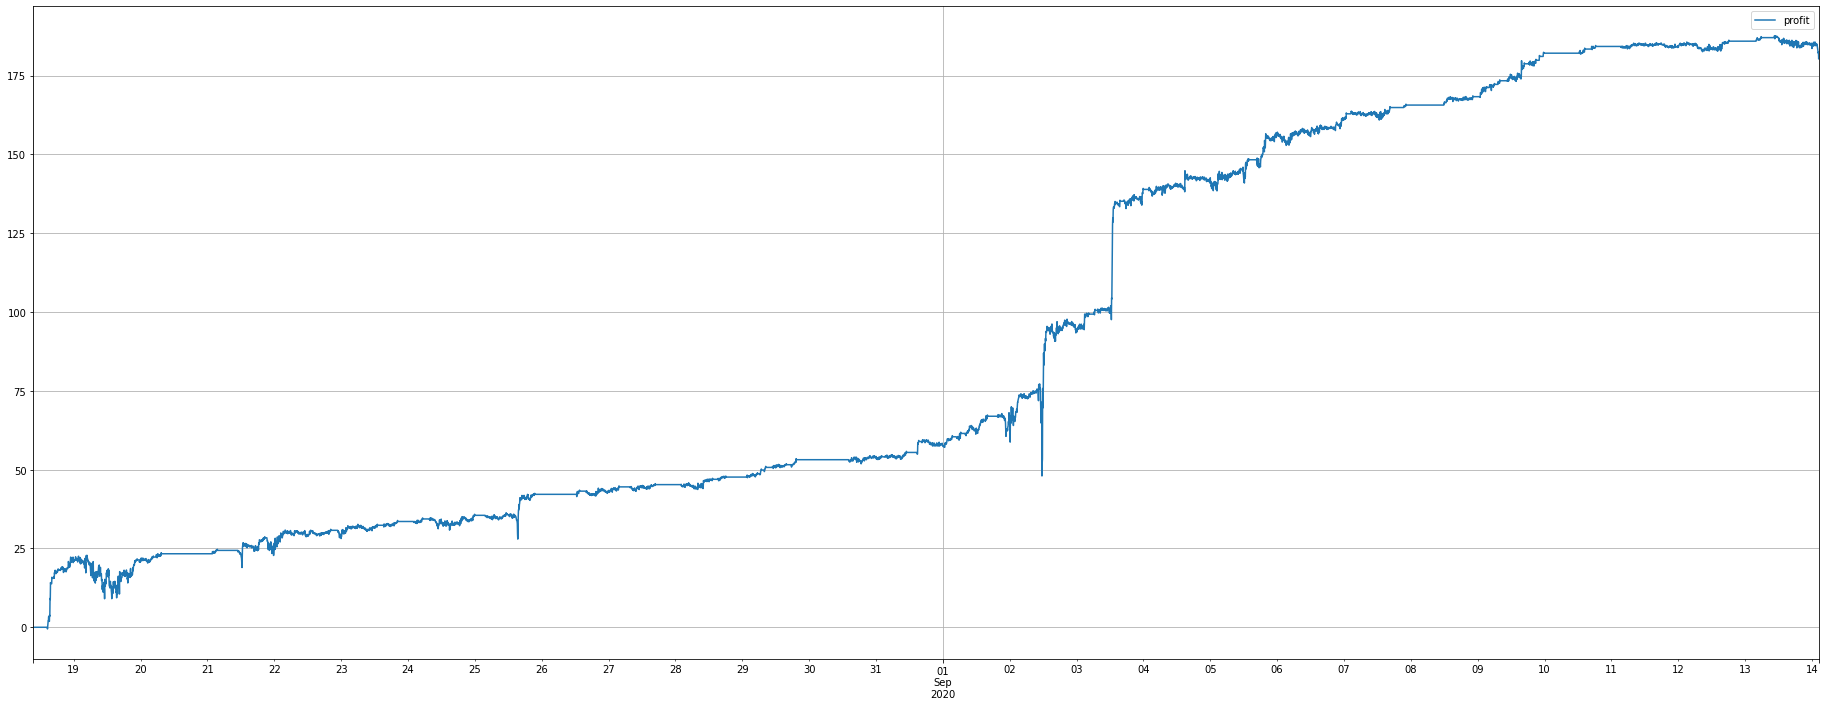

In [15]:
symbol = 'ETH'
trade_symbols = [symbol+'USD_201225', symbol+'USD_200925', symbol+'USD_PERP']
fee = 0.0002
account = []
diff = df[trade_symbols[0]]+df[trade_symbols[2]]-2*df[trade_symbols[1]]
diff_mean = diff.ewm(alpha=0.001).mean()
e = Exchange(trade_symbols, initial_balance=10000, taker_fee=fee)
for row in df[trade_symbols].dropna().iloc[30:].iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/(15*prices[trade_symbols[2]]*fee),1)
    now_amount = e.account[trade_symbols[2]]['amount']
    if aim_amount - now_amount < -1:
        trade_amount = 1
        e.Buy(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Sell(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Sell(trade_symbols[2],prices[trade_symbols[2]],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = 1
        e.Sell(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Buy(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Buy(trade_symbols[2],prices[trade_symbols[2]],trade_amount)

e.df = pd.DataFrame(index=df[trade_symbols].dropna().iloc[30:].index, columns=['margin','profit'], data=account)
e.df['profit'].plot(figsize=(32,12), grid=True, legend=True)

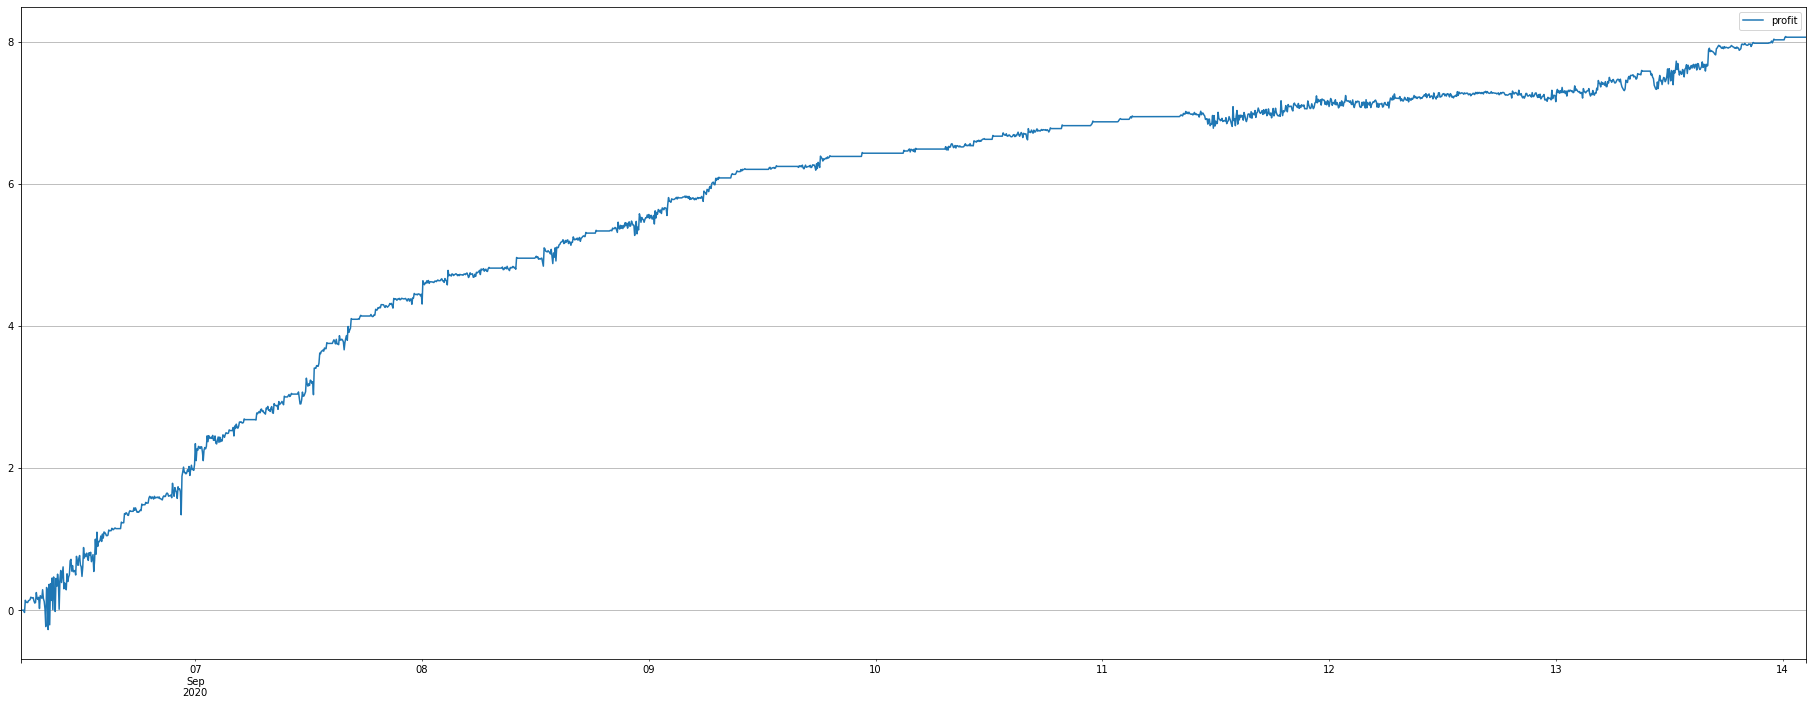

In [16]:
symbol = 'LINK'
trade_symbols = [symbol+'USD_201225', symbol+'USD_200925', symbol+'USD_PERP']
fee = 0.0002
account = []
diff = df[trade_symbols[0]]+df[trade_symbols[2]]-2*df[trade_symbols[1]]
diff_mean = diff.ewm(alpha=0.001).mean()
e = Exchange(trade_symbols,initial_balance=10000,taker_fee=fee)
for row in df[trade_symbols].dropna().iloc[30:].iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/(15*prices[trade_symbols[2]]*fee),1)
    now_amount = e.account[trade_symbols[2]]['amount']
    if aim_amount - now_amount < -1:
        trade_amount = 1
        e.Buy(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Sell(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Sell(trade_symbols[2],prices[trade_symbols[2]],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = 1
        e.Sell(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Buy(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Buy(trade_symbols[2],prices[trade_symbols[2]],trade_amount)

e.df = pd.DataFrame(index=df[trade_symbols].dropna().iloc[30:].index, columns=['margin','profit'], data=account)
e.df['profit'].plot(figsize=(32,12), grid=True, legend=True);

回測結果可以發現此策略可穩定累積報酬，收益回撤的現象比較不明顯，長期會是良好的套利工具

### ５.手續費敏感性
由於同時需要操作3個合約，開倉後平倉共需要8份的手續費，因此手續費對策略的影響很大，如果有萬1的手續費，可以進一步減小差價網格間距，BTC的回測結果如下圖：

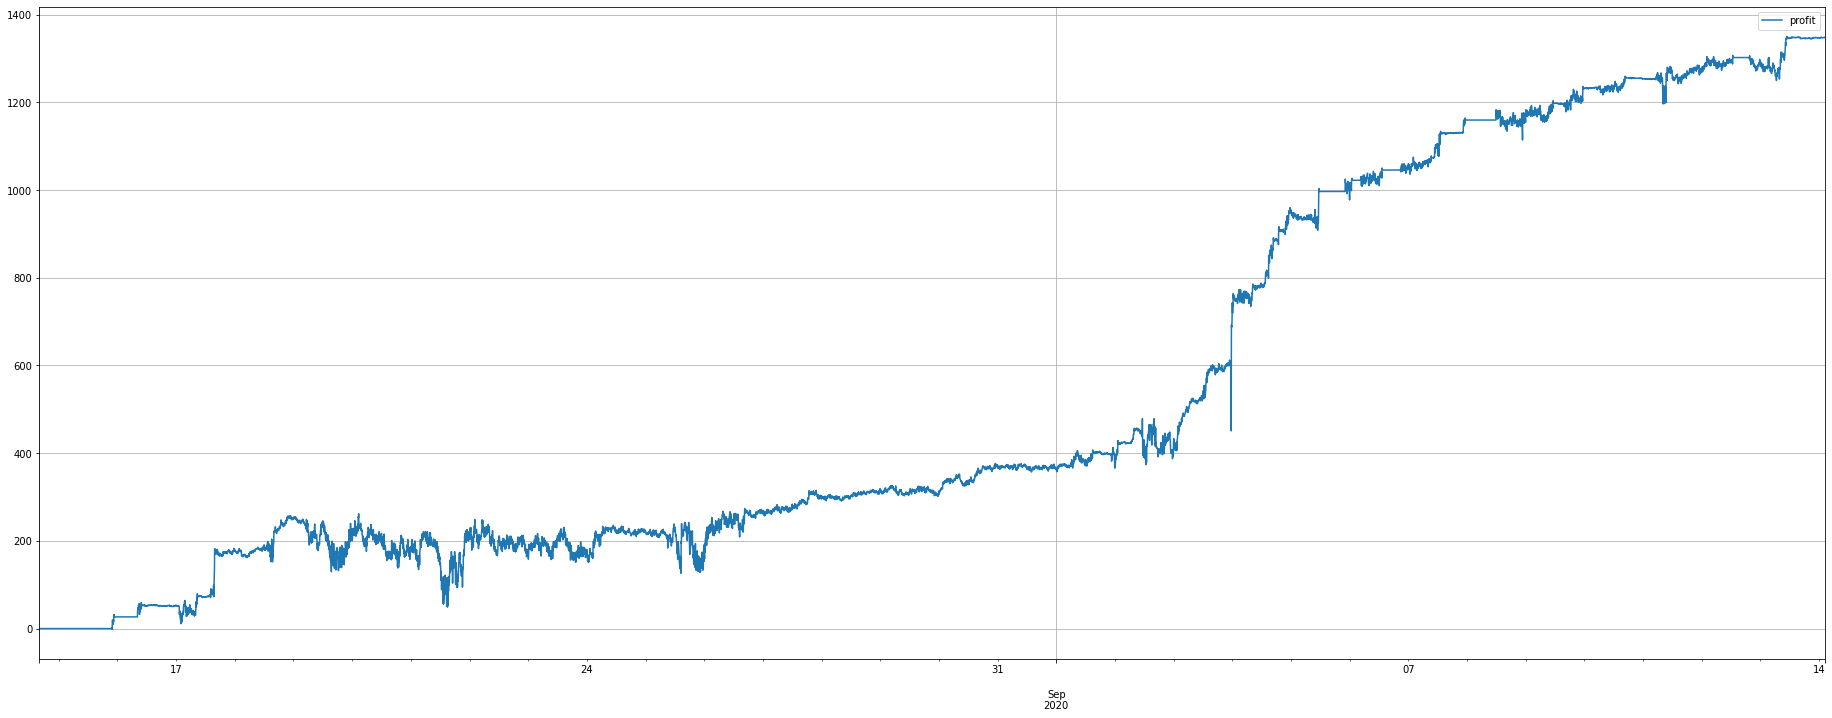

In [17]:
# 萬1手續費
trade_symbols = ['BTCUSD_201225', 'BTCUSD_200925', 'BTCUSD_PERP']
account = []
diff = df['BTCUSD_201225']+df['BTCUSD_PERP']-2*df['BTCUSD_200925']
diff_mean = diff.ewm(alpha=0.001).mean()
e = Exchange(trade_symbols, initial_balance=10000, taker_fee=0.0001)
for row in df[trade_symbols].dropna().iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/30,1)
    now_amount = e.account['BTCUSD_PERP']['amount']
    if aim_amount - now_amount < -1:
        trade_amount = now_amount - aim_amount
        e.Buy('BTCUSD_200925',prices['BTCUSD_200925'],2*trade_amount)
        e.Sell('BTCUSD_201225',prices['BTCUSD_201225'],trade_amount)
        e.Sell('BTCUSD_PERP',prices['BTCUSD_PERP'],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = aim_amount - now_amount
        e.Sell('BTCUSD_200925',prices['BTCUSD_200925'],2*trade_amount)
        e.Buy('BTCUSD_201225',prices['BTCUSD_201225'],trade_amount)
        e.Buy('BTCUSD_PERP',prices['BTCUSD_PERP'],trade_amount)
    
e.df = pd.DataFrame(index=df[trade_symbols].dropna().index, columns=['margin','profit'], data=account)
e.df['profit'].plot(figsize=(32,12), grid=True, legend=True);

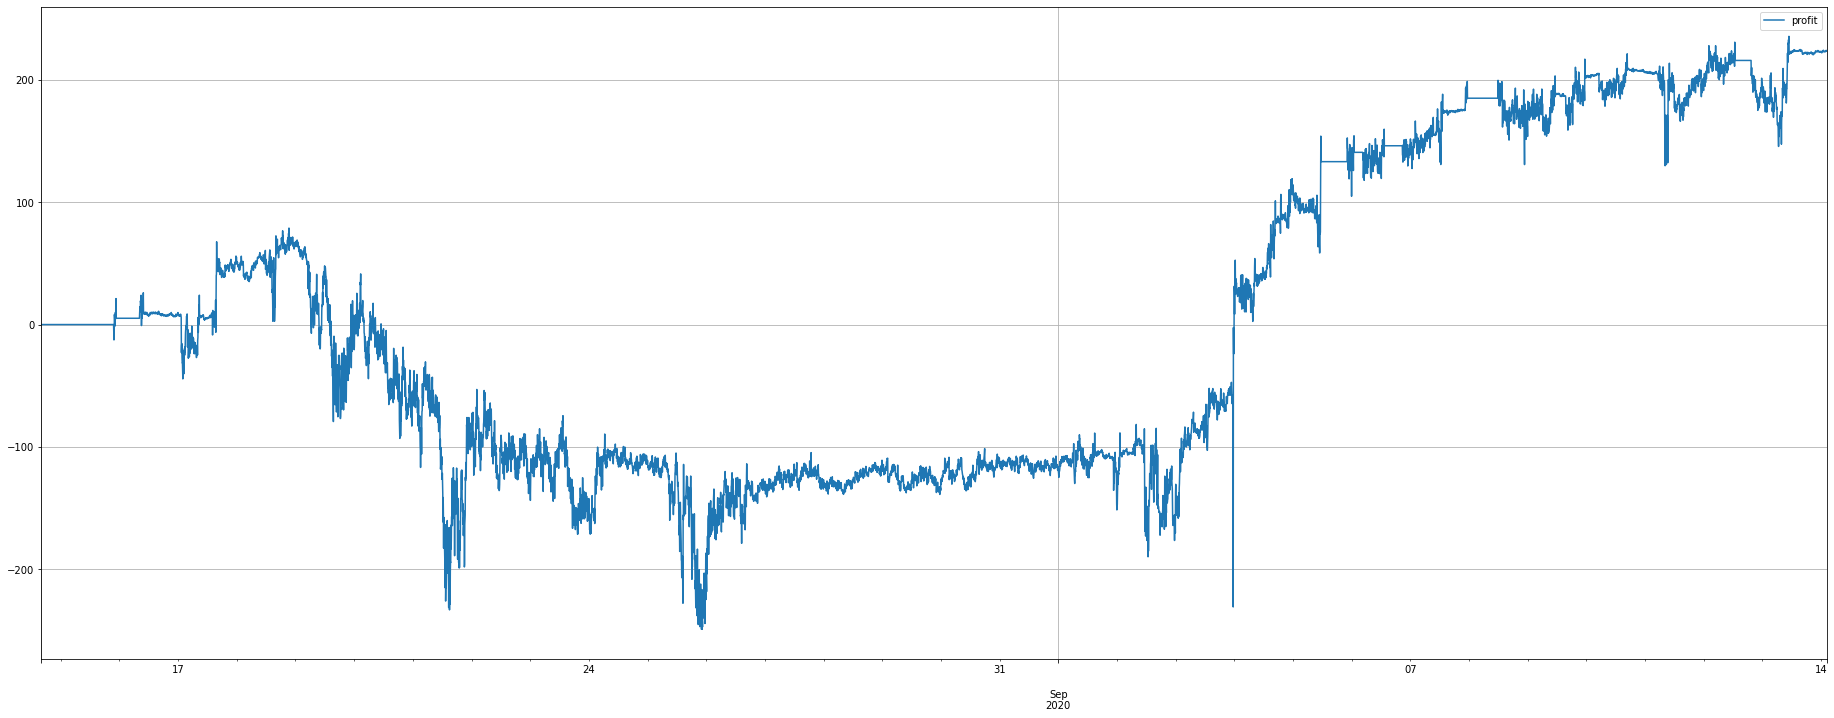

In [18]:
# 萬3手續費
trade_symbols = ['BTCUSD_201225', 'BTCUSD_200925', 'BTCUSD_PERP']
account = []
diff = df['BTCUSD_201225']+df['BTCUSD_PERP']-2*df['BTCUSD_200925']
diff_mean = diff.ewm(alpha=0.001).mean()
e = Exchange(trade_symbols, initial_balance=10000, taker_fee=0.0003)
for row in df[trade_symbols].dropna().iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/30,1)
    now_amount = e.account['BTCUSD_PERP']['amount']
    if aim_amount - now_amount < -1:
        trade_amount = now_amount - aim_amount
        e.Buy('BTCUSD_200925',prices['BTCUSD_200925'],2*trade_amount)
        e.Sell('BTCUSD_201225',prices['BTCUSD_201225'],trade_amount)
        e.Sell('BTCUSD_PERP',prices['BTCUSD_PERP'],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = aim_amount - now_amount
        e.Sell('BTCUSD_200925',prices['BTCUSD_200925'],2*trade_amount)
        e.Buy('BTCUSD_201225',prices['BTCUSD_201225'],trade_amount)
        e.Buy('BTCUSD_PERP',prices['BTCUSD_PERP'],trade_amount)
    
e.df = pd.DataFrame(index=df[trade_symbols].dropna().index, columns=['margin','profit'], data=account)
e.df['profit'].plot(figsize=(32,12), grid=True, legend=True);


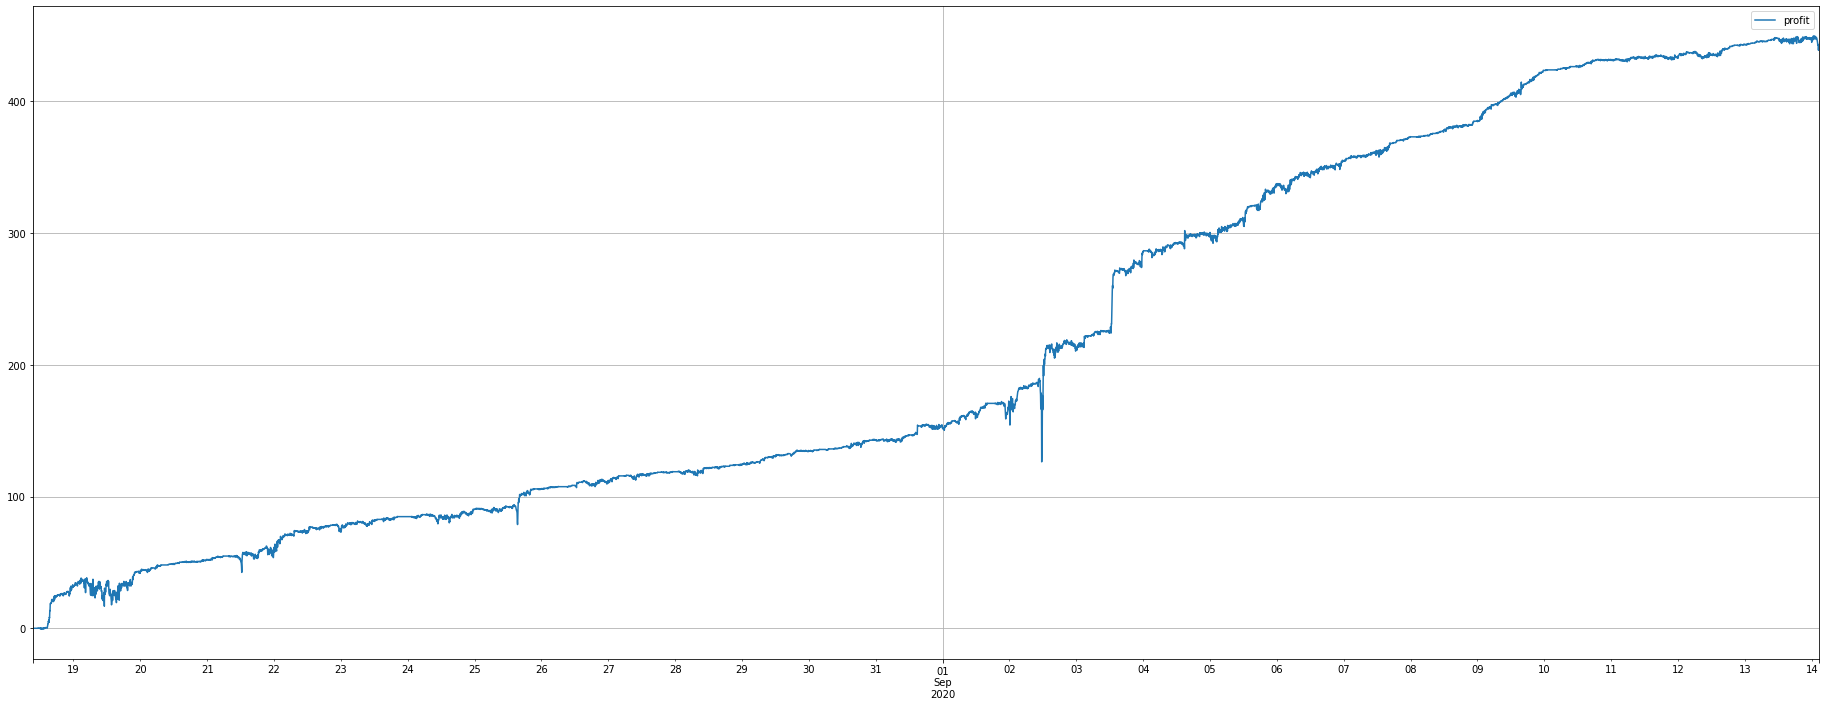

In [19]:
# ETH萬1手續費
symbol = 'ETH'
trade_symbols = [symbol+'USD_201225', symbol+'USD_200925', symbol+'USD_PERP']
fee = 0.0001
account = []
diff = df[trade_symbols[0]]+df[trade_symbols[2]]-2*df[trade_symbols[1]]
diff_mean = diff.ewm(alpha=0.001).mean()
e = Exchange(trade_symbols, initial_balance=10000, taker_fee=fee)
for row in df[trade_symbols].dropna().iloc[30:].iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/(15*prices[trade_symbols[2]]*fee),1)
    now_amount = e.account[trade_symbols[2]]['amount']
    if aim_amount - now_amount < -1:
        trade_amount = 1
        e.Buy(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Sell(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Sell(trade_symbols[2],prices[trade_symbols[2]],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = 1
        e.Sell(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Buy(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Buy(trade_symbols[2],prices[trade_symbols[2]],trade_amount)

e.df = pd.DataFrame(index=df[trade_symbols].dropna().iloc[30:].index, columns=['margin','profit'], data=account)
e.df['profit'].plot(figsize=(32,12), grid=True, legend=True);

經過比較可以發現此策略對手續費有極高的敏感度，若是過高的手續費可能導致利潤的磨損，因此此策略建議以連接手續費相對較低或是有打折的交易平台API進行操作，較能獲得相對合理的收益

### 6.結論
套利的目的是尋找穩定的差價，差價的差價更為穩定，因蝶式套利的鋒線要比跨期、期現少很多，也可以手動操作。